# Deepportfolio

A methodology that explores to design ortfolios based on identifying non-linear relationships between stocks


In [1]:
import copy

import pandas as pd
import numpy as np


from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
import keras.backend as K

from sklearn.preprocessing import StandardScaler  
import utils.returns_preprocessing as preproc
import utils.eigen_portfolios_functions as eg_functions

%load_ext autoreload
%autoreload 2

2023-02-04 18:28:57.298739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Reading the data

In [2]:
# load from persisted data
df_prices = pd.read_csv('./data/all_stock_prices.csv')
df_prices.index = df_prices['Unnamed: 0']
df_prices = df_prices.drop('Unnamed: 0', axis = 1)
df_prices.head()

,^BVSP,TAEE11.SA,PETR4.SA,BBDC4.SA,BBAS3.SA,GGBR4.SA,ITSA4.SA,VALE3.SA,USIM5.SA,B3SA3.SA
Unnamed: 0,,,,,,,,,,
2013-01-15,61728.0,22.799999,19.820000,13.292220,26.700001,17.920000,5.420308,41.160000,12.32,4.516666
2013-01-16,61787.0,22.600000,19.840000,13.359929,26.860001,17.889999,5.451914,40.900002,12.20,4.466666
2013-01-17,62194.0,22.799999,19.709999,13.580872,26.809999,18.100000,5.541462,40.980000,12.46,4.600000
2013-01-18,61956.0,23.500000,19.580000,13.630762,26.200001,17.900000,5.557265,40.610001,12.30,4.640000
2013-01-21,61900.0,23.200001,19.389999,13.573744,25.930000,17.900000,5.546730,40.580002,12.03,4.663333


In [4]:
# load test results - equivalent to the index returns to compare with
import pickle
with open("./data/eigen_portfolios_test_pickle_normalized_weights.pickle", "rb") as infile:
    eigen_portfolios_test = pickle.load(infile)

<AxesSubplot:>

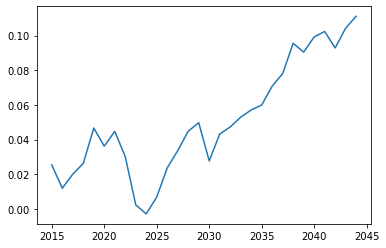

In [5]:
# set a test return
sector_returns = eigen_portfolios_test[8]
sector_returns['test_cumulative_returns'].plot()

In [6]:
sector_returns['weights']

[0.03147590399810555,
 0.14826799586241504,
 0.11910470713551718,
 0.13286976307944032,
 0.13314838247781224,
 0.0900030023192343,
 0.10153849105070109,
 0.1419272890782127,
 0.10166446499856172]

### Preprocessing

In [7]:
# test experiment
# split in train and test
test_period = 150
train_history = 300
date = '2021-01-02'
risk_free_rate = 0.01
index_ticker ='^BVSP'
high_correlation_treshold = 0.25 # depending of the sector an statistical analysis might be performed

df_returns = preproc.get_normal_returns_from_prices(df_prices)
df_returns_without_index = df_returns.drop(index_ticker, axis = 1)

df_returns_train, df_returns_test = preproc.splitting_dataset_by_window(df_returns_without_index, date, train_history, test_period)

# y_train
y_train = eg_functions.get_portfolio_returns(df_returns_train, sector_returns['weights'])
# caluclate according to the sample te porcentage to reeplace
y_train_amended = y_train.copy()
y_train_amended[y_train_amended < -.05] = risk_free_rate
y_train_amended[0] = 0


# y_test
y_test = eg_functions.get_portfolio_returns(df_returns_test, sector_returns['weights'])
# caluclate according to the sample te porcentage to reeplace
y_test_amended = y_test.copy()
y_test_amended[y_test_amended < -.05] = risk_free_rate
y_test_amended[0] = 0


### setting objective

According to literature, several articles tend to beat the index by diregarding high correaltion/covariance periods replacing the drops inder certain treshold to a predefined one

For the brazilian market, different from others indexes, drops are quite severe, hnce high correlations regimes are for drops higher than 20% in the overall sample

<AxesSubplot:>

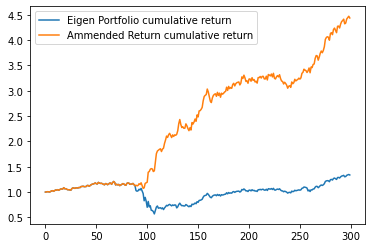

In [8]:
y_reference = y_train.copy()
y_reference[0] = 0
relative_percentage_reference = y_train + 1
lp_reference =  (relative_percentage_reference.cumprod())


#relative_percentage = (y_amended /100) + 1
relative_percentage = y_train_amended  + 1
lp_amended =  (relative_percentage.cumprod()) 


# plot comparison
#pd.Series(np.array(y_reference), index=pd.date_range(start='01/06/2012', periods=240, freq='W')).plot(label='Eigen Portfolio Return', legend=True) 
#pd.Series(np.array(y_amended), index=pd.date_range(start='01/06/2012', periods=240, freq='W')).plot(label='Ammended Return', legend=True)   

pd.Series(np.array(lp_reference)).plot(label='Eigen Portfolio cumulative return', legend=True) 
pd.Series(np.array(lp_amended)).plot(label='Ammended Return cumulative return', legend=True)   



### Autoencoding part

Phase 1. Auto-encoding
- Train an auto-encoder model compressing market information.
- Rank stocks by 2-norm difference then select subset of them as our portfolio.
- Page 7 of the paper: ReLU + linear as activation functions
- Weights , L2 regularization


Some problems I did not figure out (or the paper did not mention about the details):

- which weekly return/what data to be used? (what can represent best market information?)
- How to do the data preprocessing?
- How to perform 4-fold validation in Deep Learning?

### Autoencoding

For this we foxus only in start from the calibration section as the index itself is not a problem to represent

### Conclusion

The restrictions of the last layer,only allow us to use holding strategy (as softmx works well when ever the weights are positive and added up turns 1). other startegies such as shorting, still don't converge to a reasonable sets of weights.

This impose a problem as to when the eigen vectors are released, the returns described by them, are not possible to replicate with an autoencoder as it is designed now, (at least at this stage), due to some eigenvectors certainly are significant leveraged (which means, normalized acrivations are not )

The authors said that evolving to other startegies, is a work in progress, as such, working with other activation functions 



NOTE: PERHAPS, BY WORKING WITH LOG-RETURNS, LEVERAGED EIGENPORTFOLIOS OR EIGENVECTORS WITH COMPONENTS SIGNIFICANT BIGGER THAN ONE, MIGHT BE REDUCED

In [979]:
encoder_params = {'encoding_dim': 9,
                  'optimizer':'sgd', 
                  'loss':'mean_squared_error',
                  'l2_penalty': 0.01, 
                  'epochs': 500, 
                  'batch_size': 100, 
                  'shuffle' : False,
                  'output_activation': 'softmax'}


model = autoencoder_portfolio_calibration_fit(df_returns_train[1:], y_train_amended[1:], encoder_params)

Epoch 1/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9748
Epoch 2/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9745
Epoch 3/500
3/3 [==============================] - 0s 14ms/step - loss: 0.9742
Epoch 4/500
3/3 [==============================] - 0s 13ms/step - loss: 0.9740
Epoch 5/500
3/3 [==============================] - 0s 14ms/step - loss: 0.9737
Epoch 6/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9734
Epoch 7/500
3/3 [==============================] - 0s 13ms/step - loss: 0.9731
Epoch 8/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9728
Epoch 9/500
3/3 [==============================] - 0s 12ms/step - loss: 0.9725
Epoch 10/500
3/3 [==============================] - 0s 11ms/step - loss: 0.9722
Epoch 11/500
3/3 [==============================] - 0s 11ms/step - loss: 0.9719
Epoch 12/500
3/3 [==============================] - 0s 11ms/step - loss: 0.9717
Epoch 13/500
3/3 [==============================]

3/3 [==============================] - 0s 12ms/step - loss: 0.9238
Epoch 205/500
3/3 [==============================] - 0s 11ms/step - loss: 0.9236
Epoch 206/500
3/3 [==============================] - 0s 11ms/step - loss: 0.9234
Epoch 207/500
3/3 [==============================] - 0s 11ms/step - loss: 0.9232
Epoch 208/500
3/3 [==============================] - 0s 11ms/step - loss: 0.9229
Epoch 209/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9227
Epoch 210/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9225
Epoch 211/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9223
Epoch 212/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9221
Epoch 213/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9219
Epoch 214/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9217
Epoch 215/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9214
Epoch 216/500
3/3 [=======================

3/3 [==============================] - 0s 10ms/step - loss: 0.8856
Epoch 407/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8854
Epoch 408/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8852
Epoch 409/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8851
Epoch 410/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8849
Epoch 411/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8847
Epoch 412/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8846
Epoch 413/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8844
Epoch 414/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8842
Epoch 415/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8841
Epoch 416/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8839
Epoch 417/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8838
Epoch 418/500
3/3 [=======================

#### 

## validating

# how do I resolve the portfolios with short positions?? softmax only accepts hold ... ASK Edson Why tanh does not work, this is needed to replicate eigenportfolios with short positions!

10/10 [==============================] - 0s 732us/step


<AxesSubplot:xlabel='Unnamed: 0'>

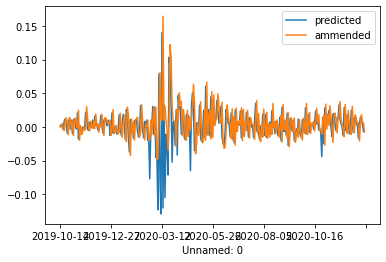

In [980]:
# train
portfolio_returns_train_hat = pd.Series(portfolio_returns_predict(df_returns_train[1:], model))
pd.Series(portfolio_returns_train_hat).plot(label = 'predicted', legend = True)
#portfolio_returns_train_hat.plot(label = 'predicted', legend = True)
y_train_amended.plot(label = 'ammended', legend = True)

max: 0.781263591986098
mean: 0.014903781449533924


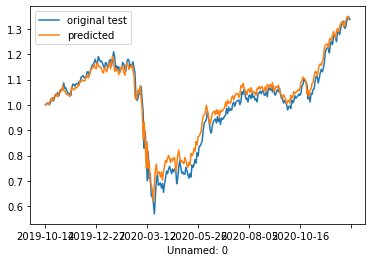

In [976]:
lp_test =  ((y_train + 1).cumprod())

lp_test_ammended =  ((y_train_amended + 1).cumprod())

lp_predicted =((portfolio_returns_train_hat  + 1).cumprod()) 

pd.Series(lp_test).plot(label = 'original test', legend = True)
#pd.Series(lp_test_ammended).plot(label = 'test ammended', legend = True)
pd.Series(lp_predicted).plot(label = 'predicted', legend = True)

# bad training! ??? it seems so!
diff_test_benchmark = []
for i in range(len(lp_predicted)):
    diff_test_benchmark.append((lp_predicted[i] - [lp_test[1:]][0]))

print('max:', np.max(diff_test_benchmark))
print('mean:', np.mean(diff_test_benchmark))

max: 0.775529609647077
mean: 0.01166474081134997


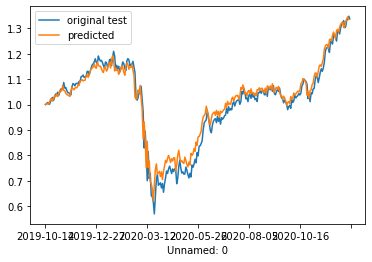

In [982]:
lp_test =  ((y_train + 1).cumprod())

lp_test_ammended =  ((y_train_amended + 1).cumprod())

lp_predicted =((portfolio_returns_train_hat  + 1).cumprod()) 

pd.Series(lp_test).plot(label = 'original test', legend = True)
#pd.Series(lp_test_ammended).plot(label = 'test ammended', legend = True)
pd.Series(lp_predicted).plot(label = 'predicted', legend = True)

# bad training! ??? it seems so!
diff_test_benchmark = []
for i in range(len(lp_predicted)):
    diff_test_benchmark.append((lp_predicted[i] - [lp_test[1:]][0]))

print('max:', np.max(diff_test_benchmark))
print('mean:', np.mean(diff_test_benchmark))

## Important!

This results show that no convergence was hit, as what it has been predicted does not represent the returns intented to learn s they were generated by weights, or eigenvectors that are not possible to get from the current autoencoder architecture!

5/5 [==============================] - 0s 944us/step


<AxesSubplot:xlabel='Unnamed: 0'>

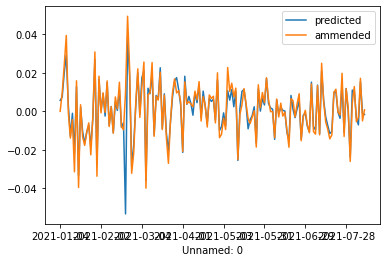

In [983]:
# test
portfolio_returns_hat = pd.Series(portfolio_returns_predict(df_returns_test.dropna(), model))
#pd.Series(portfolio_returns_hat[:,0]).plot(label = 'predicted', legend = True)
portfolio_returns_hat.plot(label = 'predicted', legend = True)
y_test_amended.plot(label = 'ammended', legend = True)

max: 0.22843560252926332
mean: 0.008879955611226308


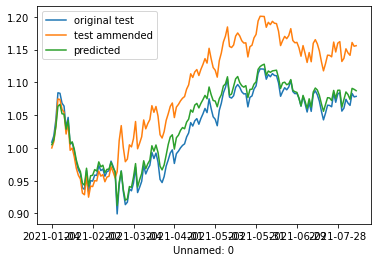

In [978]:
lp_test =  ((y_test + 1).cumprod())

lp_test_ammended =  ((y_test_amended + 1).cumprod())

lp_predicted =((portfolio_returns_hat  + 1).cumprod()) 

pd.Series(lp_test).plot(label = 'original test', legend = True)
pd.Series(lp_test_ammended).plot(label = 'test ammended', legend = True)
pd.Series(lp_predicted).plot(label = 'predicted', legend = True)

diff_test_benchmark = []
for i in range(len(lp_predicted)):
    diff_test_benchmark.append((lp_predicted[i] - [lp_test[1:]][0]))

print('max:', np.max(diff_test_benchmark))
print('mean:', np.mean(diff_test_benchmark))


max: 0.234629318950496
mean: 0.013965057020364092


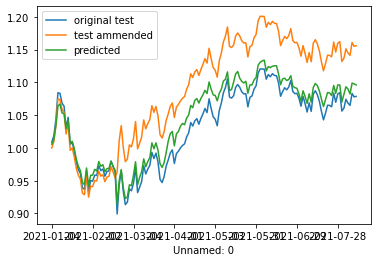

In [984]:
lp_test =  ((y_test + 1).cumprod())

lp_test_ammended =  ((y_test_amended + 1).cumprod())

lp_predicted =((portfolio_returns_hat  + 1).cumprod()) 

pd.Series(lp_test).plot(label = 'original test', legend = True)
pd.Series(lp_test_ammended).plot(label = 'test ammended', legend = True)
pd.Series(lp_predicted).plot(label = 'predicted', legend = True)

diff_test_benchmark = []
for i in range(len(lp_predicted)):
    diff_test_benchmark.append((lp_predicted[i] - [lp_test[1:]][0]))

print('max:', np.max(diff_test_benchmark))
print('mean:', np.mean(diff_test_benchmark))

# methods

In [775]:
## Test

## set the y_objectve

"""
weights_expriment = [0.15, 0.2, 0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
#weights_expriment = sector_returns['weights']
y_train_exp = df_returns_train[1:].apply(lambda x: np.dot(weights_expriment, np.transpose(x)), axis = 1)

encoder_params_exp = {'encoding_dim': 6,
                  'optimizer':'sgd', 
                  'loss':'mean_squared_error',
                  'l2_penalty': 0.01, 
                  'epochs': 500, 
                  'batch_size': 100, 
                  'shuffle' : False,
                  'output_activation': 'softmax'}


#model = autoencoder_portfolio_calibration_fit(df_returns_train[1:], y_train[1:], encoder_params)
model_exp = autoencoder_portfolio_calibration_fit(df_returns_train[1:], y_train_exp, encoder_params_exp)


# train
portfolio_returns_train_hat = pd.Series(portfolio_returns_predict(df_returns_train[1:], model_exp))
pd.Series(portfolio_returns_train_hat).plot(label = 'predicted', legend = True)
#portfolio_returns_train_hat.plot(label = 'predicted', legend = True)
y_train_exp.plot(label = 'ammended', legend = True)

# test
lp_test =  ((y_train_exp + 1).cumprod())
lp_predicted =((portfolio_returns_train_hat  + 1).cumprod()) 

pd.Series(lp_test).plot(label = 'original test', legend = True)
pd.Series(lp_predicted).plot(label = 'predicted', legend = True)

"""

"\nweights_expriment = [0.15, 0.2, 0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]\n#weights_expriment = sector_returns['weights']\ny_train_exp = df_returns_train[1:].apply(lambda x: np.dot(weights_expriment, np.transpose(x)), axis = 1)\n\nencoder_params_exp = {'encoding_dim': 6,\n                  'optimizer':'sgd', \n                  'loss':'mean_squared_error',\n                  'l2_penalty': 0.01, \n                  'epochs': 500, \n                  'batch_size': 100, \n                  'shuffle' : False,\n                  'output_activation': 'softmax'}\n\n\n#model = autoencoder_portfolio_calibration_fit(df_returns_train[1:], y_train[1:], encoder_params)\nmodel_exp = autoencoder_portfolio_calibration_fit(df_returns_train[1:], y_train_exp, encoder_params_exp)\n\n\n# train\nportfolio_returns_train_hat = pd.Series(portfolio_returns_predict(df_returns_train[1:], model_exp))\npd.Series(portfolio_returns_train_hat).plot(label = 'predicted', legend = True)\n#portfolio_returns_train_hat.plot(la

In [886]:
encoder_params = {'encoding_dim': 5,
                  'optimizer':'sgd', 
                  'loss':'mean_squared_error',
                  'l2_penalty': 0.01, 
                  'epochs': 500, 
                  'batch_size': 10, 
                  'shuffle' : False}


from tensorflow.python.ops import math_ops
#We used our own loss function because the one provided by tensorflow was not consistent
"""def loss(mse, regularizer, lambd, num_input, batch_size):
    with tf.compat.v1.variable_scope("loss"):
        loss = tf.reduce_sum(mse + lambd * regularizer)/(num_input * batch_size * 2)
    return loss

def mse(output, x):
    with tf.compat.v1.variable_scope('mse'):
        mse = tf.math.squared_difference(output, x)
    return mse"""

def autoencoder_portfolio_calibration_fit(x, y_target, network_params):
    
    # input autoencoder params
    encoding_dim = network_params['encoding_dim']
    l2_penalty = network_params['l2_penalty']
    optimizer =  network_params['optimizer']
    loss = network_params['loss']
    epochs = network_params['epochs']
    batch_size = network_params['batch_size']
    shuffle = network_params['shuffle'] 
    output_activation = network_params['output_activation']
    
    # target tensor -> y_target
    target = Input(shape=(1,))
    # connect all layers
    input_tensor = Input(shape=(x.shape[1],))
    encoded = Dense(encoding_dim, activation='tanh', kernel_regularizer=regularizers.l2(l2_penalty))(input_tensor)
    #decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(l2_penalty))(encoded)
    decoded = Dense(x.shape[1], activation= output_activation, kernel_regularizer=regularizers.l2(l2_penalty))(encoded)
    
    
  
    def custom_rmse_loss(y_true, y_pred, input_tensor):

        y_pred_dot = K.dot(y_pred, K.transpose(input_tensor))
        loss = K.sqrt(K.mean(K.square(y_pred_dot - y_true))) 
        
        return loss
    
 
    
    # construct and compile deep learning routine
    deep_learner = Model([input_tensor, target], decoded)
    
    deep_learner.add_loss(custom_rmse_loss(target, decoded, input_tensor))
    deep_learner.compile(optimizer=optimizer, loss = None, run_eagerly=True)
    #deep_learner.fit(x, y_target, shuffle=shuffle, epochs=epochs, batch_size = batch_size)    # fit the model
    
    ss = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    ss.fit(x)
    x = ss.transform(x)
    
    deep_learner.fit([x, y_target] , None, shuffle=shuffle, epochs=epochs, batch_size = batch_size)
    
    # this make inferences compatible
    final_model = Model(deep_learner.input[0], deep_learner.output)
    
    return final_model


def portfolio_returns_predict(x, model):
    "Get the models weights to estimate returns"
    weights = copy.deepcopy(model.predict(x))
    x = np.array(x)
    returns = []
    for i in range(len(weights)):
        returns.append(np.dot(weights[i], np.transpose(x[i])))
    
        
    # is not a single weight
    #weights = K.eval(model.layers[2].weights[1])
    #weights = weights / len(weights)
    #returns = x.apply(lambda row: np.dot(weights,  np.transpose(row)), axis = 1)
    
    return returns

def two_norm_diff(y, y_hat):
    return np.linalg.norm((y_hat - y))


#deep_learner.save('model/retrack_s' + str(s) + '.h5') # for validation phase use

In [356]:
[r for r in copy.deepcopy(model.predict(df_returns_test_percentage))]

2/2 [==============================] - 0s 1ms/step


[array([0.17121194, 0.08056416, 0.09392512, 0.10110077, 0.12036341,
        0.08461755, 0.09399891, 0.12357321, 0.13064495], dtype=float32),
 array([0.16977128, 0.08156641, 0.09443094, 0.10118392, 0.12030277,
        0.0851921 , 0.09474925, 0.12341576, 0.12938763], dtype=float32),
 array([0.17071769, 0.08143232, 0.09370236, 0.10167806, 0.11892188,
        0.08582488, 0.09463169, 0.1235403 , 0.12955081], dtype=float32),
 array([0.17155854, 0.08070768, 0.09414965, 0.10136665, 0.11907317,
        0.0854389 , 0.09359576, 0.12410951, 0.13000016], dtype=float32),
 array([0.17104635, 0.08230277, 0.09349701, 0.10141133, 0.11889952,
        0.08559954, 0.09537191, 0.12232798, 0.12954359], dtype=float32),
 array([0.16959205, 0.08090571, 0.0942708 , 0.10130294, 0.11986163,
        0.08575038, 0.09436683, 0.12440885, 0.12954086], dtype=float32),
 array([0.17093444, 0.0813898 , 0.09380634, 0.10168638, 0.11950629,
        0.08521257, 0.09452917, 0.12320833, 0.12972675], dtype=float32),
 array([0.170

In [389]:
copy.deepcopy(model.predict(df_returns_test_percentage))

2/2 [==============================] - 0s 1ms/step


array([[-7.74908229e-04, -1.14399684e-03,  1.98549125e-04,
        -1.38635072e-03,  5.27951634e-04, -1.55994901e-04,
         3.97703116e-04,  6.42906234e-04, -3.96127987e-04],
       [-7.73549778e-04, -1.11745473e-03,  1.95762143e-04,
        -1.22963556e-03,  5.59753156e-04, -2.05895398e-04,
         3.89272143e-04,  6.29483082e-04, -3.72263661e-04],
       [-8.29226105e-04, -1.08146516e-03,  2.57105799e-04,
        -1.17645424e-03,  5.27212978e-04, -3.35574616e-04,
         3.64381704e-04,  5.80794993e-04, -2.85826507e-04],
       [-7.65720382e-04, -1.05317833e-03,  2.11015926e-04,
        -1.11151475e-03,  5.03822754e-04, -2.96412851e-04,
         3.53883021e-04,  5.67594019e-04, -2.70100049e-04],
       [-7.87531375e-04, -1.06601545e-03,  2.25598691e-04,
        -1.16380758e-03,  5.45122195e-04, -2.84038368e-04,
         3.59883532e-04,  5.89654548e-04, -3.12695454e-04],
       [-7.57003087e-04, -1.17724063e-03,  1.14070950e-04,
        -1.55969255e-03,  5.78726642e-04,  4.543608

## TEST

## Backlog

In [528]:


# Calibration test
def autoencoder_portfolio_calibration_fit(x, y_target, network_params):
    
    # input autoencoder params
    encoding_dim = network_params['encoding_dim']
    l2_penalty = network_params['l2_penalty']
    optimizer =  network_params['optimizer']
    loss = network_params['loss']
    epochs = network_params['epochs']
    batch_size = network_params['batch_size']
    shuffle = network_params['shuffle'] 
    
    # connect all layers
    input_img = Input(shape=(x.shape[1],))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(l2_penalty))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(l2_penalty))(encoded)

    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer=optimizer, loss=loss)

    ss = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    ss.fit(x)
    x = ss.transform(x)  
    
    deep_learner.fit(x, y_target, shuffle=shuffle, epochs=epochs, batch_size = batch_size)    # fit the model
    
    return deep_learner




In [ ]:
"""
def CustomLoss(y_true, y_pred, input_tensor):
    print(y_pred)
    return K.binary_crossentropy(y_true, y_pred) + K.mean(input_tensor)

X = np.random.uniform(0,1, (1000,10))
y = np.random.randint(0,2, 1000)

inp = Input(shape=(10,))
hidden = Dense(100, activation='relu')(inp)
out = Dense(1, activation='sigmoid')(hidden)
target = Input((1,))
model = Model([inp,target], out)

model.add_loss( CustomLoss( target, out, inp ) )
model.compile(loss=None, optimizer='adam')
model.fit(x=[X,y], y=None, epochs=3)
"""

deep_learner = Model(input_tensor, decoded)
    
    def custom_loss(input_tensor):
        def _loss(y_true, y_pred):
            
            K.print_tensor(input_tensor, message='input_tensor = ')
            #K.print_tensor(y_pred, message='y_pred = ')
            
            #y_pred = K.dot(y_pred, input_tensor)
            diff = math_ops.squared_difference(y_pred, y_true)  #squared difference
            loss = K.mean(diff, axis=-1) #mean over last dimension
            return loss
        return _loss
    
    deep_learner.compile(optimizer=optimizer, loss=custom_loss(input_tensor))
